# Задание 4

Подключаем необходимые библиотеки

In [3]:
# подгружаем библиотеки
import pywt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne

### Задание 1
Выберите любой файл в формате EDF.



In [5]:
data_from_edf = mne.io.read_raw_edf('eeg1.edf', preload=True)

Extracting EDF parameters from C:\Users\dvm10\Desktop\Platforms\Task4\eeg1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1790207  =      0.000 ...  6992.996 secs...


In [6]:
data_from_edf.info

<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fp1-REF, EEG Fp2-REF, EEG F3-REF, EEG F4-REF, EEG C3-REF, ...
 chs: 21 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2011-11-11 11:11:11 UTC
 nchan: 21
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: >
>


### Задание 2
По аннотации из датасета определите, где в записи ЭЭГ указан приступ. Постройте график временной зависимости ЭЭГ в момент приступа (выбирайте диапазон времени и масштаб так, чтобы было наглядно).


Using matplotlib as 2D backend.


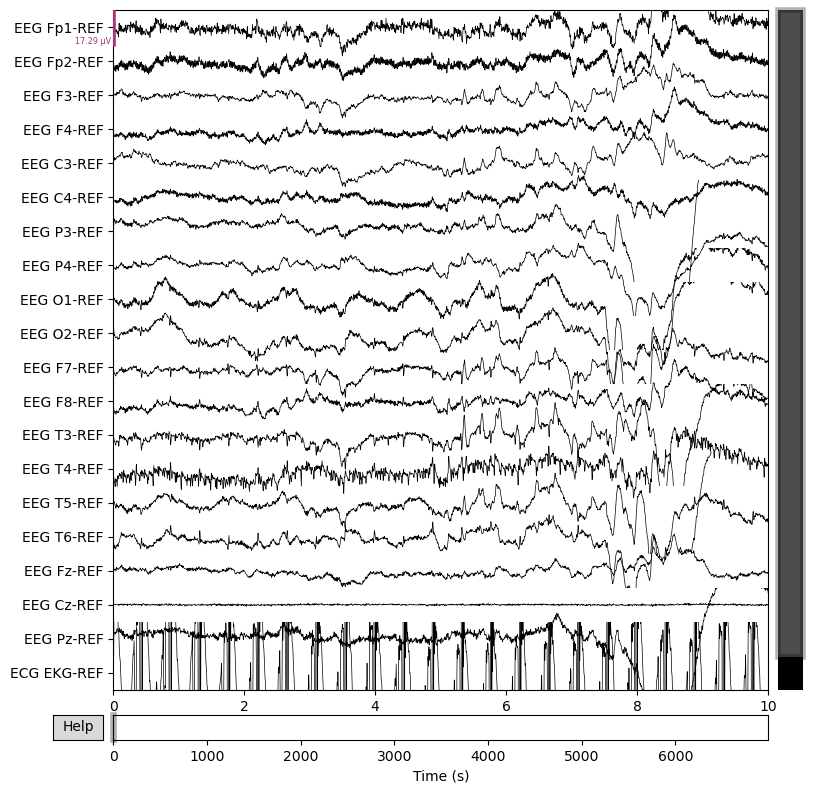

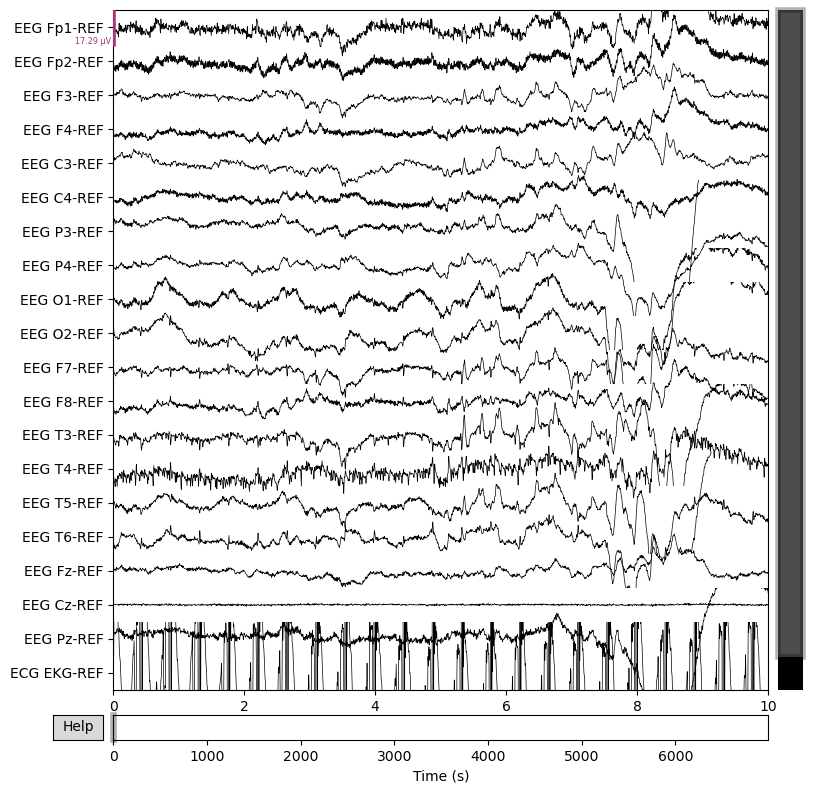

In [8]:
data_from_edf.plot(scalings = 'auto', show = False)

In [9]:
data_from_edf.ch_names

['EEG Fp1-REF',
 'EEG Fp2-REF',
 'EEG F3-REF',
 'EEG F4-REF',
 'EEG C3-REF',
 'EEG C4-REF',
 'EEG P3-REF',
 'EEG P4-REF',
 'EEG O1-REF',
 'EEG O2-REF',
 'EEG F7-REF',
 'EEG F8-REF',
 'EEG T3-REF',
 'EEG T4-REF',
 'EEG T5-REF',
 'EEG T6-REF',
 'EEG Fz-REF',
 'EEG Cz-REF',
 'EEG Pz-REF',
 'ECG EKG-REF',
 'Resp Effort-REF']

In [10]:
#время приступа узнаем из аннотации из базы данных
eeg_data, eeg_times = data_from_edf.get_data(return_times=True)

In [12]:
print('число отчетов во временном ряду:',len(eeg_times))

число отчетов во временном ряду: 1790208


In [13]:

# устанавливаем диапазон для обработки данных
t_index_begin = np.where(eeg_times > 1 * 300 - 300)[0][0]
t_index_end = np.where(eeg_times > 1 * 460 + 300)[0][0]
t = eeg_times[t_index_begin:t_index_end]
# значение времени = конец сигнала
T = t[-1] - t[0]
# число элементов во временном ряду
N = len(t)

# удалаем ненужные сигналы из массива данных ЭЭГ
# eeg_data = np.delete(eeg_data, [len(eeg_data)-1], axis = 0)

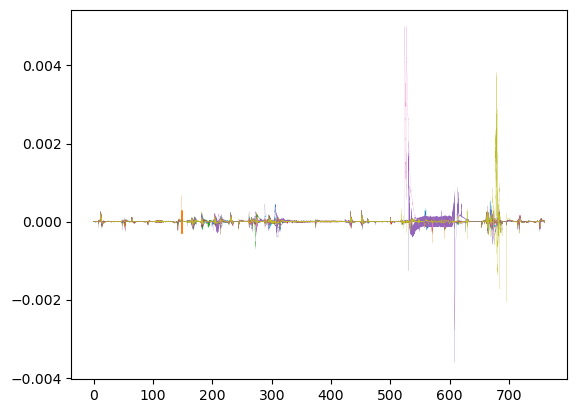

In [14]:
for i in range(len(data_from_edf.ch_names)-2):
    plt.plot(t, eeg_data[i, t_index_begin:t_index_end], linewidth = 0.1)

plt.show()

### Задание 3
Сделайте усреднение всех каналов ЭЭГ в один (нужно сложить все каналы и разделить на их количество).


In [16]:
# сделаем простой устредненный сигнал - все каналы в один массив
y=[]
for i in range(len(eeg_data)-2):
    y =+ eeg_data[i, t_index_begin:t_index_end]
y =y/(len(eeg_data)-1)
plt.plot(t,y)

### Задание 4
Удалите из сигнала все частоты выше 60 Гц. Для этого преобразованного сигнала:
-	постройте спектрограмму сигнала;
-	постройте вейвлет-преобразование (скейлограмму).

In [19]:
# фильтр Баттерфорда для вырезания полосы частот
from scipy import signal
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    filtered_data = signal.lfilter(b, a, data)
    return filtered_data

In [21]:
# модули для обработки временных рядов (убрать тренд и аппроксимировать)
class Detrending:
    def plot(t,y,slope,intercept):
        fig = plt.figure(figsize=(10,7))
        ax = plt.subplot(111)
        plt.scatter(t,y, s=5)
        plt.plot(t, slope*t + intercept, 'r',
                 label='y={:.2f}x+{:.2f}'.format(slope,intercept))
        plt.grid(True)
        plt.legend(fontsize=12)
        plt.xlabel('time')
        plt.ylabel('Y')
        plt.show()

    def line_fit(t,y):
        from scipy import stats
        slope, intercept, r_value, p_value, std_err = stats.linregress(t,y)
        #line = slope*t + intercept
        return slope, intercept

    def trend_off(t,y):
        from scipy import stats
        slope, intercept, r_value, p_value, std_err = stats.linregress(t,y)
        line = slope*t + intercept

        y_nontrend = y-line
        return y_nontrend

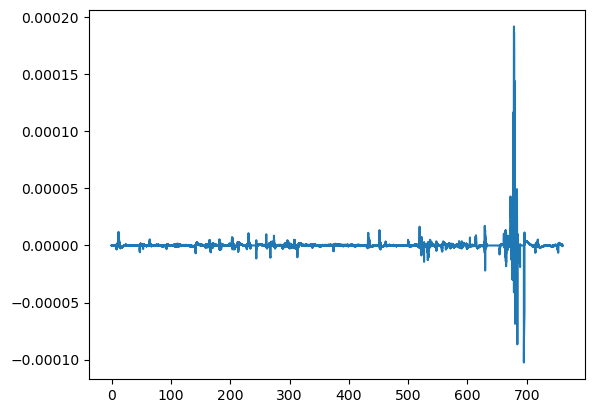

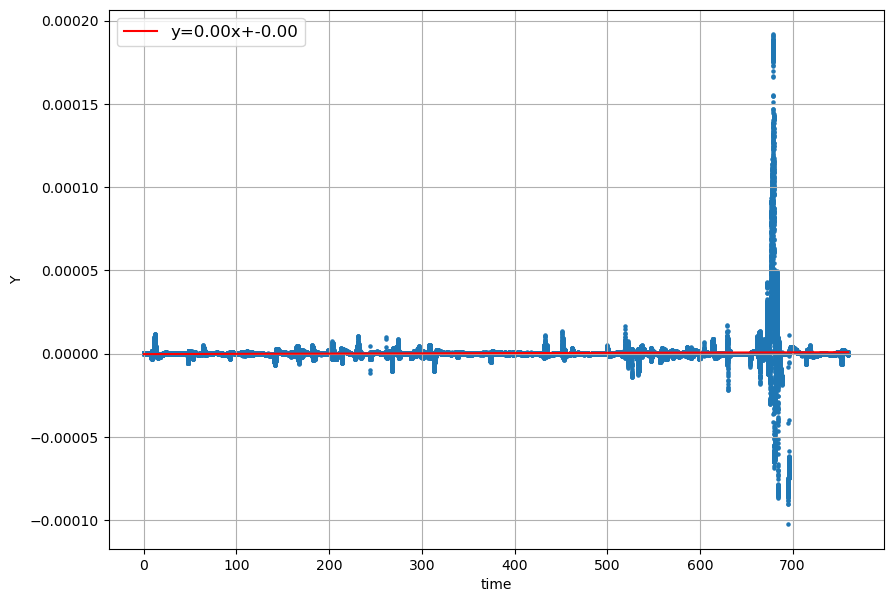

In [22]:
slope, intercept = Detrending.line_fit(t, y)
Detrending.plot(t,y,slope, intercept)

y = Detrending.trend_off(t,y)
plt.plot(t,y)

In [23]:
# Пример предобработки: фильтрация сигнала
fs = len(t)/(T)  # частота дискретизации
lowcut = 1 # нижняя частота среза фильтра
highcut = 60 # верхняя частота среза фильтра
y_filt = np.apply_along_axis(butter_bandpass_filter, axis=0, arr=y, lowcut=lowcut, highcut=highcut, fs=fs)
plt.plot(t,y, t, y_filt)
y = y_filt

In [24]:
# перечень вейвлетов
wavlist_continuous = pywt.wavelist(kind='continuous')
wavlist_discrete = pywt.wavelist(kind='discrete')

In [25]:
# устанавливаем максимальное значение сдвига
scale_max = 300
scale_min = 3
# массив точек с масштабом (линейный и логарифмический масштаб)
scales = np.linspace(scale_min, scale_max, num = 25, endpoint=True)

wavelet_core = 'morl'
fs = len(t)/(T)  # частота дискретизации
dt = 1/ fs
coef, freqs = pywt.cwt(y, scales, wavelet_core, sampling_period = dt)

In [26]:
# вейвлет-преобразование построено относительно масштаба материнского вейвлета
# чтобы вернуться в область частот - необходимо перевести масштаб в частоту!
f = pywt.scale2frequency(wavelet_core, scales)/dt

# изобразим график зависимости частоты и масштаба
plt.figure(figsize=(7, 7))
plt.grid()
plt.yticks(np.arange(min(freqs), max(freqs), (max(freqs) - min(freqs))/10))
plt.xticks(np.arange(min(scales), max(scales), (max(scales) - min(scales))/10))
plt.ylabel('Частота[Герц]', fontsize=12)
plt.xlabel('масштаб в вейвлет преобразовании', fontsize=12)
plt.plot(scales, freqs,'.-')

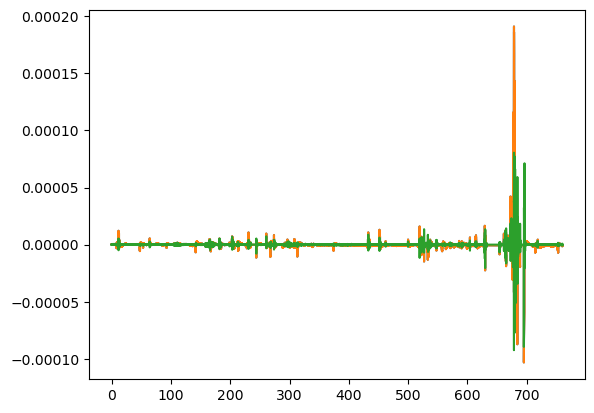

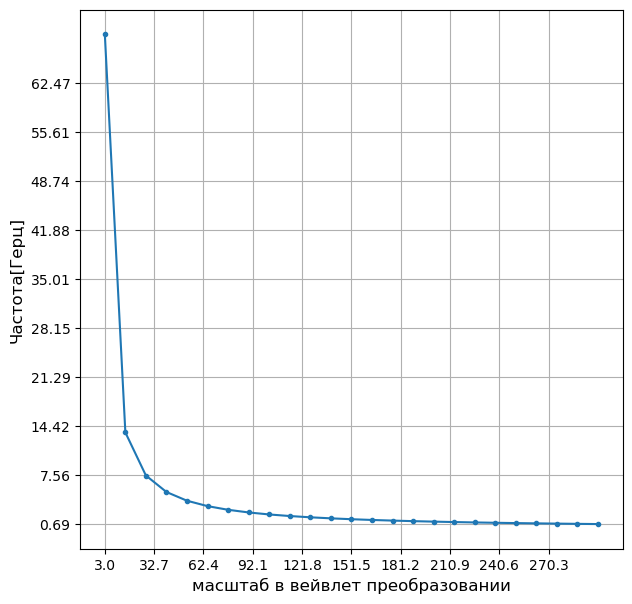

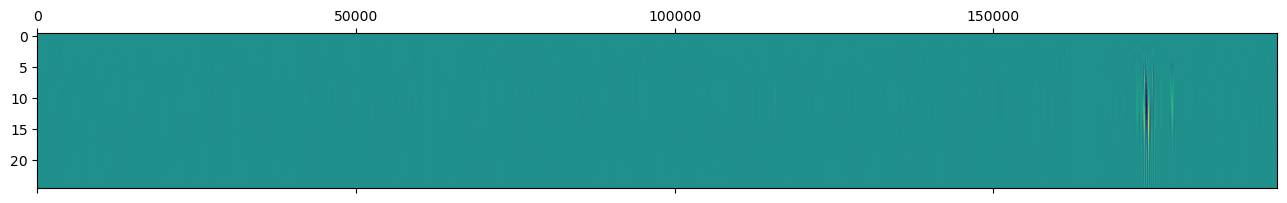

In [27]:
plt.matshow(coef,aspect = 'auto')
plt.show()

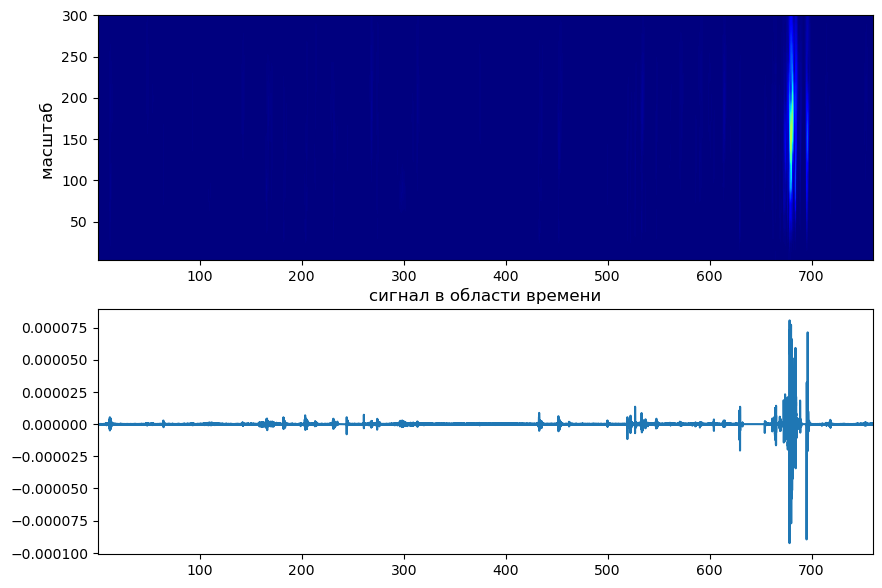

In [28]:
plt.figure(figsize=(10, 7))

ax1 = plt.subplot(211)

plt.imshow(abs(coef), cmap='jet', aspect='auto', extent=[t[0], t[-1], max(scales), min(scales)], vmax=abs(coef).max(), vmin=abs(coef).min())
plt.gca().invert_yaxis ()
plt.ylabel('масштаб ', fontsize=12)

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(t, y)
ax2.set_title("сигнал в области времени")
plt.show()

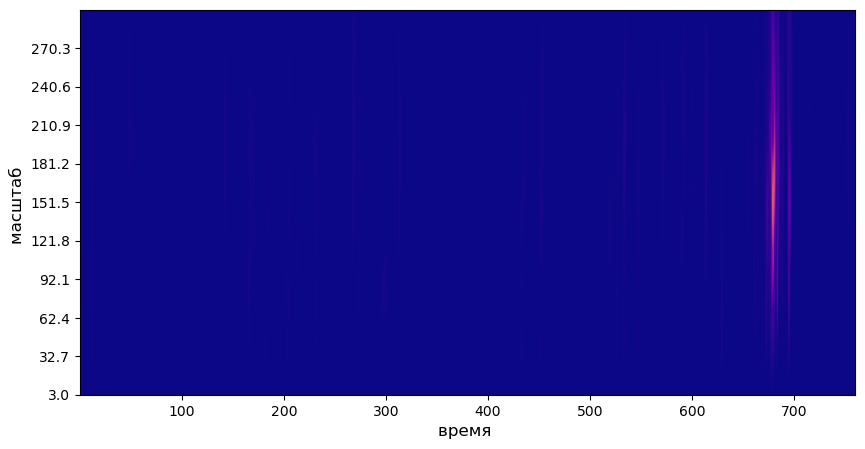

In [29]:
plt.figure(figsize=(10, 5))
plt.imshow(abs(coef), extent=[t[0], t[-1], max(scales), min(scales)], interpolation='bilinear', cmap='plasma', aspect='auto')

plt.gca().invert_yaxis ()
plt.yticks(np.arange(min(scales), max(scales), (max(scales) - min(scales))/10))
plt.ylabel('масштаб ', fontsize=12)
plt.xlabel('время ', fontsize=12)
plt.show()

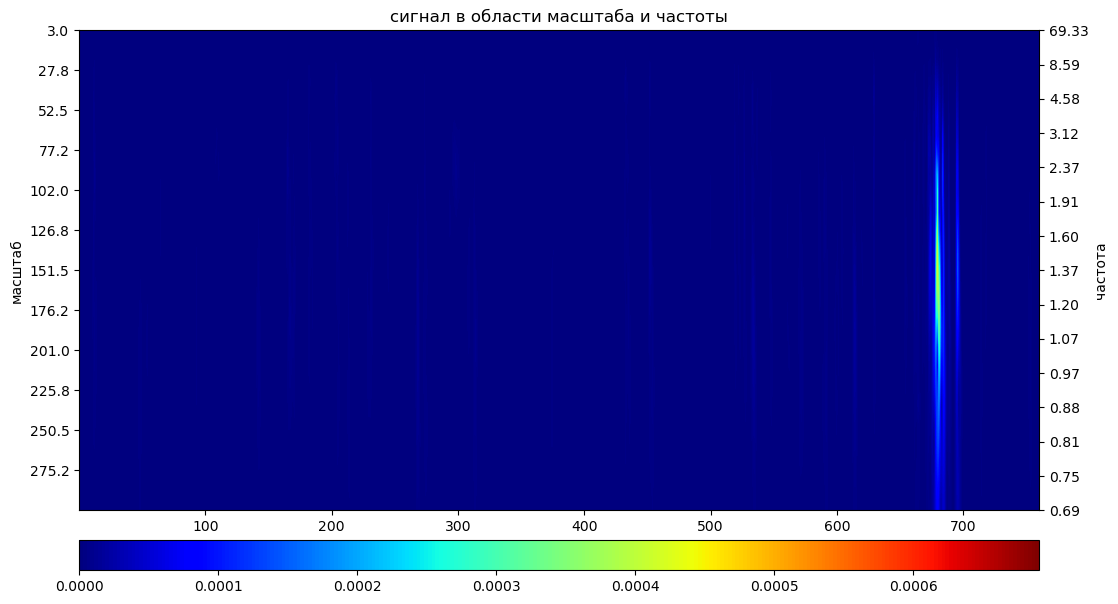

In [51]:
from matplotlib.figure import cbar
from matplotlib.ticker import FuncFormatter
import mpl_toolkits.axes_grid1 as axes_grid1
import matplotlib.ticker as ticker

#Plotting dual axis scalogram
f1 = plt.figure()
f1.set_size_inches(12, 6)


ax1 = axes_grid1.host_axes([0.1, 0.1, 0.8, 0.80])
axc = f1.add_axes([0.1, 0, 0.8, 0.05])
im1 = ax1.imshow(abs(coef), cmap='jet', aspect='auto', interpolation='bilinear',
                 extent=[t[0], t[-1], max(scales), min(scales)],
                 vmax=abs(coef).max(), vmin=-abs(coef).min())

cbar.Colorbar(axc, im1, orientation='horizontal')

ax1.set_yticks(np.arange(min(scales), max(scales), (max(scales) - min(scales))/12))

ax2 = ax1.twinx()
# make ticklabels on the top invisible
ax2.axis["top"].toggle(ticklabels=False)

formatter = FuncFormatter(lambda x, pos: '{:0.2f}'.format(pywt.scale2frequency(wavelet_core, x)/dt))
ax2.yaxis.set_major_formatter(formatter)
ax2.set_ylim(ax1.get_ylim())

# make number ticks what we want

ax2.yaxis.set_major_locator(ticker.LinearLocator(numticks = 15))

ax2.set_ylabel('частота')
ax1.set_ylabel('масштаб')
ax2.set_xlabel('время')

ax1.set_title('сигнал в области масштаба и частоты')

plt.show()